# Basis embedding (qiskit)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using basis (bit-string) embedding (non-conventional domain)
* measure all qubits (back to conventional domain)
* apply 2D IFT --> fidelity computation

Basis embedding:

* circuit family #1 (CX: controlled X) from https://arxiv.org/abs/1803.01958

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import qiskit
from qiskit import *

### Prerequisites

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

## 1) Generating an artificial image of the sky (frequency domain)

In [3]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 10 #20
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 8.69317912e-03-1.2369599e-02j  1.05563337e-02+1.1215195e-02j
   1.65619422e-03-7.6693838e-04j  1.63226649e-02-3.7084147e-03j
  -8.43662675e-03+1.7704438e-02j -5.74846112e-04-2.1636568e-02j
   9.22625139e-03-8.3098989e-03j -8.22359882e-03+2.4669843e-03j
   9.41192359e-03-7.1601686e-03j -7.24234199e-03-1.7329959e-02j]
 [ 4.62051528e-03-3.5328357e-03j -8.72016605e-03+5.4520327e-03j
  -3.90144368e-03-1.0922149e-02j  1.01212133e-02-4.1611912e-03j
  -4.32031549e-04-7.6828385e-04j  1.42688844e-02+1.3719331e-02j
   2.87875123e-02-6.1033098e-03j  3.30901868e-03+3.7454464e-03j
   7.92620773e+01+8.0803284e+01j  4.89175227e-03-5.5425898e-03j]
 [-1.48982629e-02-6.2418263e-03j  1.39005166e-02+1.2396429e-02j
   6.63036248e-03+6.1830641e-03j -7.31441006e-03-1.2411638e-02j
  -6.92010112e-03-5.8091024e-04j  1.08755017e-02-1.7804258e-02j
   1.42023275e-02+4.7824481e-03j -5.49209723e-03-3.5980782e-03j
   1.19630741e-02-1.8699704e-02j  6.94300933e-03+1.1803995e-02j]
 [ 7.97659438e-03+9.3240775e-03j -6.0

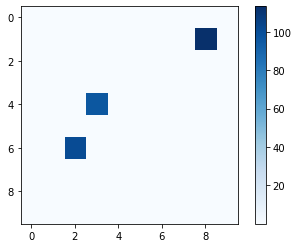

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying 2D FT (Fourier domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 204.64833  +2.32014877e+02j   96.96855  -2.12646523e+01j
  -217.8174   -1.51605820e+02j -119.88192  -3.12672615e+01j
   148.2283   +1.29759407e+01j   97.09182  +7.20123215e+01j
   -21.667604 +1.30237015e+02j  -37.148926 -8.55106735e+01j
  -112.82381  -2.23914352e+02j  -36.99874  +6.58340607e+01j]
 [  15.444371 -9.32251587e+01j -121.4244   +2.28300507e+02j
    23.915113 +2.01527847e+02j   70.14037  -2.02463684e+02j
   -54.049137 -2.33138794e+02j    8.572702 +9.94688568e+01j
    63.512375 +1.75665024e+02j  -83.73372  +4.17994347e+01j
   -48.787766 -5.08197975e+01j  126.936005 -1.66745590e+02j]
 [ 131.7793   -2.06124210e+01j  153.75237  +1.43704462e+01j
  -148.58112  -1.14923258e+01j -249.8223   +9.74384384e+01j
   108.42662  +3.92977028e+01j  250.48666  -1.72038681e+02j
   -27.22043  -5.18214951e+01j -155.6259   +1.80858688e+02j
   -64.69987  +4.46845093e+01j    0.9992072-1.20678764e+02j]
 [  99.28738  -3.69272385e+01j  129.3629   +1.01939650e+01j
    47.131424 +1.41687637e+02j  -26.4

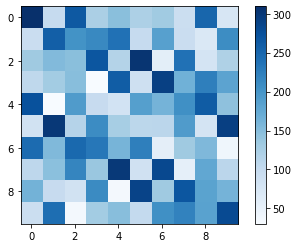

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 8.964522e-14
Imaginaries MSE: 1.0395972e-13


## 3) Data encoding: basis embedding (non-conventional domain)

In [8]:
# encoding binary data onto qubits
def encoding2(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) # set quantum state |0> by default for all qubits

        if binary[i]=='1':
            qc.x(off_set+i) # act as a CX (controlled X gate)
    
    off_set += len(binary)

    return off_set

In [9]:
number_of_entries = visibilities.shape[0] * visibilities.shape[1]
number_of_bits_real = 32
number_of_bits_imag = 32
number_of_bits = number_of_bits_real + number_of_bits_imag
off_set = 0

# encoding (n bits encoded onto n qubits)
qc = QuantumCircuit(number_of_entries*number_of_bits)
for i in range(0, visibilities.shape[0]):
    for j in range(0, visibilities.shape[1]):
            binary_real = float_to_bin_real(visibilities[i, j].real)
            binary_imag = float_to_bin_imag(visibilities[i, j].imag)
            binary = binary_real+binary_imag
            off_set = encoding2(qc, binary, off_set)

# measurement
qc.measure_all()
backend = Aer.get_backend('aer_simulator') # Qiskit's staple simulator (CHOICE MOTIVATION?)
job = backend.run(qc, shots=1, memory=True) 
output = job.result().get_memory()[0]
out = reverse(output)

# readout
chunks_real = []
chunks_imag = []
for i in range(0, number_of_entries):
    chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) # real parts represented every 64 bits starting from the first one
    chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) # imaginary parts represented every 64 bits starting after the first occurence of a real part 

readout = []
for i in range(0, len(chunks_real)):
    readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

readout = np.array(readout).reshape(n , n).astype('complex64')
print(readout)

[[ 204.64833  +2.32014877e+02j   96.96855  -2.12646523e+01j
  -217.8174   -1.51605820e+02j -119.88192  -3.12672615e+01j
   148.2283   +1.29759407e+01j   97.09182  +7.20123215e+01j
   -21.667604 +1.30237015e+02j  -37.148926 -8.55106735e+01j
  -112.82381  -2.23914352e+02j  -36.99874  +6.58340607e+01j]
 [  15.444371 -9.32251587e+01j -121.4244   +2.28300507e+02j
    23.915113 +2.01527847e+02j   70.14037  -2.02463684e+02j
   -54.049137 -2.33138794e+02j    8.572702 +9.94688568e+01j
    63.512375 +1.75665024e+02j  -83.73372  +4.17994347e+01j
   -48.787766 -5.08197975e+01j  126.936005 -1.66745590e+02j]
 [ 131.7793   -2.06124210e+01j  153.75237  +1.43704462e+01j
  -148.58112  -1.14923258e+01j -249.8223   +9.74384384e+01j
   108.42662  +3.92977028e+01j  250.48666  -1.72038681e+02j
   -27.22043  -5.18214951e+01j -155.6259   +1.80858688e+02j
   -64.69987  +4.46845093e+01j    0.9992072-1.20678764e+02j]
 [  99.28738  -3.69272385e+01j  129.3629   +1.01939650e+01j
    47.131424 +1.41687637e+02j  -26.4

## 4) Applying 2D IFT (fidelity test)

In [10]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 8.964522e-14
Imaginaries MSE: 1.0395972e-13


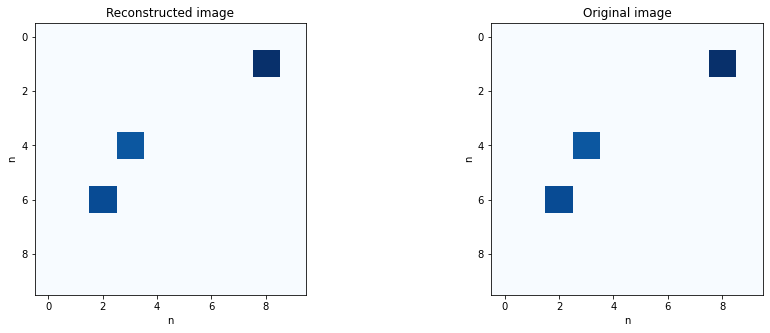

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')